In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, shutil
import torch
import time
import warnings
from botorch.exceptions import BadInitialCandidatesWarning
import pdb
import matplotlib.pyplot as plt

tkwargs = {
    "dtype": torch.double,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
}
import head
import numpy as np
from head.metrics import euclidean_dist
from botorch.models.gp_regression import SingleTaskGP
from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
from botorch import fit_gpytorch_model
from botorch.optim.optimize import optimize_acqf_discrete
from botorch.acquisition.monte_carlo import qUpperConfidenceBound
from botorch.acquisition.objective import LinearMCObjective
from matplotlib.cm import ScalarMappable

N_UVVIS_SAMPLES = 10
N_SAS_SAMPLES = 100
NUM_GRID_PERDIM = 100
BATCH_SIZE = 32
N_ITERATIONS = 32
NUM_RESTARTS = 64 
RAW_SAMPLES = 1024
N_INIT_SAMPLES = 8

R_mu = 20
R_sigma = 1e-2
SHAPE_PARAM = 0.67
SPECTRA = 'saxs'

expt = {}
EXPT_ID = 0

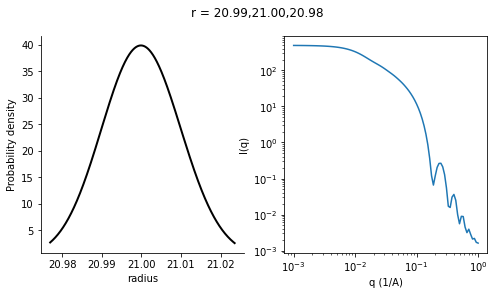

In [3]:
sim = head.EmulatorMultiShape()
sim.make_structure(r_mu=R_mu,r_sigma=R_sigma)

fig, axs = plt.subplots(1,2,figsize=(4*2,4))

sim.plot_radii(axs[0])
axs[0].set_xlabel('radius')
axs[0].set_ylabel('Probability density')

if SPECTRA=='saxs':
    xt, yt = sim.get_saxs(shape_param = SHAPE_PARAM, n_samples=N_SAS_SAMPLES)
    axs[1].loglog(xt, yt)
    plt.setp(axs[1], xlabel='q (1/A)', ylabel='I(q)')
elif SPECTRA=='uvvis':
    xt, yt = sim.get_uvvis(shape_param = 0.67, n_samples=N_UVVIS_SAMPLES)
    axs[1].plot(xt, yt)
    plt.setp(axs[1], xlabel='wavelength (nm))', ylabel=r'I($\lambda$)')
    
fig.suptitle('r = '+','.join('%.2f'%i for i in sim.radii))
plt.show()

In [4]:
# define search space
r_mu = [5,50]
r_sigma = [1e-4,1]
shape_param = [0,1]
bounds = torch.tensor((r_mu, r_sigma, shape_param)).T.to(**tkwargs)

In [5]:
def oracle(x):
    """Scoring function at a given input location
    Uses the simulator sim to generate response spectra at a given locations
    and return a similarity score to target spectra
    """
    global EXPT_ID
    x_np = x.cpu().numpy()    
    sim.make_structure(r_mu=x_np[0],
                       r_sigma=x_np[1])
    if SPECTRA=='saxs':
        xi, yi = sim.get_saxs(shape_param = x_np[2], 
                              n_samples=N_SAS_SAMPLES)
        dist = euclidean_dist(np.log10(yi),np.log10(yt))
    elif SPECTRA=='uvvis':
        xi, yi = sim.get_uvvis(shape_param = x_np[2], 
                               n_samples=N_UVVIS_SAMPLES)
        dist = euclidean_dist(yi,yt)
        
    expt[EXPT_ID] = [xi, yi, dist]
    EXPT_ID += 1
    
    return torch.tensor([dist])

def batch_oracle(x):
    out = []
    for xi in x.squeeze(1):
        out.append(oracle(xi))
    return torch.stack(out, dim=0).to(**tkwargs)

In [6]:
from botorch.utils.sampling import draw_sobol_samples

def draw_random_batch(n_samples=6):
    train_x = draw_sobol_samples(
        bounds=bounds,n=1, q=n_samples, 
        seed=torch.randint(2021, (1,)).item()
    ).squeeze(0)
    train_obj = batch_oracle(train_x)
    return train_x, train_obj


train_x, train_obj = draw_random_batch(n_samples=N_INIT_SAMPLES)
print('Generated %d samples randomly'%N_INIT_SAMPLES, train_x.shape, train_obj.shape)
for i in range(N_INIT_SAMPLES):
    print('%d\t%s\t%s'%(i, train_x[i,...].numpy(), train_obj[i,...].numpy()))

Generated 8 samples randomly torch.Size([8, 3]) torch.Size([8, 1])
0	[36.68028682  0.12542128  0.18647571]	[-4.23002291]
1	[29.01961088  0.49228584  0.920771  ]	[-3.59999847]
2	[6.64553221 0.01405621 0.77168816]	[-7.65982676]
3	[23.81654248  0.04888971  0.10626772]	[-4.37183142]
4	[11.63823329  0.9506126   0.75671977]	[-4.52028275]
5	[18.92402828  0.44363052  0.71685582]	[-1.18536294]
6	[6.9255597  0.22295484 0.39928722]	[-14.90445614]
7	[35.01468867  0.51702561  0.57133132]	[-4.39521217]


In [7]:
def initialize_model(train_x, train_obj):
    # define models for objective and constraint
    model = SingleTaskGP(train_x, train_obj, 
    outcome_transform=Standardize(m=train_obj.shape[-1]))
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    return mll, model

mll, model = initialize_model(train_x, train_obj)

# 3. Define acqusition function
obj = LinearMCObjective(weights=torch.tensor([1.0]).to(**tkwargs))


In [8]:
from botorch.optim.optimize import optimize_acqf

def selector(f, q = BATCH_SIZE):
    new_x, _ = optimize_acqf(
        acq_function=f,
        bounds=bounds,
        q=q,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES, 
        sequential=False,
    )
    new_obj = batch_oracle(new_x)
    return new_x, new_obj

In [9]:
torch.manual_seed(2021)
import pdb

# run N_ITERATIONS rounds of BayesOpt after the initial random batch
print('Sampled ID \t Locations \t Objectives')
for iteration in range(1, N_ITERATIONS + 1):    
    print('Iteration : %d/%d'%(iteration, N_ITERATIONS))
    # fit the models
    fit_gpytorch_model(mll)

    # define the acquisition module
    acquisition = qUpperConfidenceBound(model, beta=0.1, objective=obj)
    
    # optimize acquisition functions and get new observations
    new_x, new_obj = selector(acquisition)
    for i in range(BATCH_SIZE):
        print('%d\t%s\t%s'%(i, new_x[i,...].numpy(), new_obj[i,...].numpy()))

    # update training points
    train_x = torch.cat([train_x, new_x])
    train_obj = torch.cat([train_obj, new_obj])

    # re-initialize
    mll, model = initialize_model(train_x, train_obj)

    best = train_obj.max(axis=0).values
    print('Best %.2f'%(best))

Sampled ID 	 Locations 	 Objectives
Iteration : 1/32
0	[44.53522033  0.28174611  0.48732053]	[-4.92435408]
1	[11.27987656  0.5744471   0.37415835]	[-10.0625906]
2	[22.211904    0.45573748  0.46655126]	[-4.68516397]
3	[19.0946489   0.31797213  0.66538577]	[-1.15612352]
4	[28.62639796  0.32653576  0.99479242]	[-3.50188518]
5	[42.13900227  0.51488124  0.29613066]	[-4.57800865]
6	[19.05040297  0.55702584  0.70471127]	[-0.84029114]
7	[46.43418645  0.5433899   0.08120561]	[-5.12590981]
8	[37.21097007  0.33001858  0.09661971]	[-4.25196695]
9	[29.39356071  0.64974511  0.85033992]	[-3.57658029]
10	[41.53476363  0.49288445  0.35020758]	[-4.51690245]
11	[18.85655421  0.35276662  0.61041677]	[-0.80156076]
12	[48.42973626  0.6029775   0.54384137]	[-6.17717552]
13	[5. 1. 1.]	[-9.44386005]
14	[11.03034352  0.74173109  0.62032838]	[-4.57326698]
15	[21.92063894  0.3812746   0.3890947 ]	[-4.98383188]
16	[21.72323763  0.60128524  0.57220738]	[-1.55392969]
17	[19.03096106  0.4169523   0.86458466]	[-0.6086

0	[47.09865726  0.95173861  0.42099197]	[-5.25443935]
1	[31.00575372  0.23511168  0.03328272]	[-4.07083893]
2	[12.0577897   0.91364936  0.2876721 ]	[-9.74127769]
3	[11.73579153  0.91619984  0.95415974]	[-4.62583351]
4	[42.22563549  0.95246108  0.29101777]	[-4.67521763]
5	[4.06531277e+01 3.35585787e-02 2.24370744e-01]	[-4.44009113]
6	[26.52508679  0.34560791  0.4412641 ]	[-4.17207384]
7	[28.97428463  0.97371391  0.32629554]	[-4.07695293]
8	[29.78945077  0.08759383  0.32354946]	[-4.07417583]
9	[19.74727369  0.93441155  0.50021154]	[-0.35467958]
10	[30.44947166  0.03977501  0.346355  ]	[-4.07259321]
11	[21.78443432  0.37065484  0.94507773]	[-1.61150849]
12	[22.44840667  0.43862553  0.36711805]	[-4.75013208]
13	[40.25185265  0.70201941  0.92418416]	[-5.12132978]
14	[6.3111799  0.39676411 0.99302065]	[-7.49568272]
15	[20.0626054   0.75290851  0.6728716 ]	[-0.68358427]
16	[24.92176639  0.3589623   0.55920965]	[-2.88911867]
17	[34.56115288  0.98583378  0.48118555]	[-4.12622929]
18	[42.8529450

0	[30.45524907  0.36933645  0.9308825 ]	[-3.76476121]
1	[35.38084131  0.35343004  0.65089065]	[-4.41085768]
2	[6.72734474 0.10042479 0.56789451]	[-7.62267876]
3	[23.98845527  0.76988499  0.1447482 ]	[-4.31639242]
4	[49.19796175  0.34120593  0.22942744]	[-5.45343733]
5	[8.45144411 0.90928334 0.45207438]	[-12.9961462]
6	[49.89036404  0.85785019  0.6518782 ]	[-6.3214016]
7	[39.95109344  0.8949327   0.33703513]	[-4.37374735]
8	[15.57303452  0.66533682  0.86792173]	[-2.83628678]
9	[10.78622149  0.90132382  0.91961436]	[-4.19750929]
10	[33.38215884  0.08728729  0.17460069]	[-4.12229061]
11	[17.66747529  0.1606813   0.3560924 ]	[-7.0367322]
12	[39.3410802   0.06366167  0.14993229]	[-4.34879541]
13	[1.99895234e+01 9.99999975e-05 8.73209771e-01]	[-0.00235912]
14	[19.76305431  0.2397976   0.8891527 ]	[-0.24692143]
15	[41.70915694  0.26976133  0.97176495]	[-5.28313255]
16	[17.46656709  0.31967236  0.49439047]	[-6.95636606]
17	[25.55203896  0.3876198   0.33910477]	[-4.18209791]
18	[43.86598056  0.

0	[42.53043952  0.96844035  0.47235118]	[-4.72018003]
1	[6.9505833  0.66201652 0.96495865]	[-7.38797903]
2	[17.61697514  0.19955255  0.650034  ]	[-2.05580449]
3	[44.1762499   0.82872299  0.14407211]	[-4.89797688]
4	[31.91673579  0.52699044  0.82659428]	[-3.93459201]
5	[5.55890532 0.89372557 0.43523255]	[-16.73249817]
6	[37.86763638  0.47499025  0.71226583]	[-4.67505407]
7	[8.35463873 0.71342468 0.60465968]	[-6.15339041]
8	[29.27681226  0.05521822  0.30584536]	[-4.08050346]
9	[32.93246223  0.41098992  0.82994826]	[-4.10614538]
10	[8.49134589 0.52933643 0.70899301]	[-5.95713711]
11	[38.80526046  0.33984482  0.28495385]	[-4.31862116]
12	[28.62401938  0.19300407  0.39055629]	[-4.09270716]
13	[16.95606519  0.14394632  0.87892122]	[-2.39174032]
14	[30.36930107  0.70415402  0.83022866]	[-3.85988712]
15	[20.42370958  0.1816401   0.87483004]	[-0.44223294]
16	[49.56110255  0.07548912  0.36321218]	[-5.55298328]
17	[19.61011484  0.29522306  0.22856424]	[-6.06688356]
18	[34.84534154  0.51154836  0.

0	[13.16618377  0.28376729  0.42390062]	[-9.24714279]
1	[9.0669634  0.07733543 0.41564262]	[-12.47788811]
2	[11.60826174  0.72839635  0.11323211]	[-9.93601608]
3	[36.84304719  0.72709324  0.47444695]	[-4.19984913]
4	[6.44240131 0.27224481 0.21959996]	[-15.36425686]
5	[39.04708504  0.55081418  0.8123975 ]	[-5.01633501]
6	[34.23181766  0.74068166  0.17229467]	[-4.12437963]
7	[2.00487204e+01 9.99999975e-05 8.86465282e-01]	[-0.05237329]
8	[11.71644009  0.01368738  0.09070106]	[-10.24720383]
9	[22.83637887  0.17035248  0.53390646]	[-2.07837582]
10	[39.04002301  0.1938651   0.70456929]	[-4.86141396]
11	[42.12350579  0.73676082  0.91416821]	[-5.47180176]
12	[15.23835906  0.21854906  0.93478938]	[-3.07017827]
13	[7.61282109 0.45527072 0.26167857]	[-13.66748905]
14	[29.94046064  0.76039523  0.11396564]	[-4.07241869]
15	[24.31507285  0.3213872   0.20032245]	[-4.31854916]
16	[41.28295775  0.99462534  0.21797   ]	[-4.58159256]
17	[37.48154515  0.70755301  0.58847441]	[-4.64237595]
18	[27.88502435 

KeyboardInterrupt: 

In [ ]:
# obtain best sample and corresponding objective
from botorch.acquisition import PosteriorMean
from botorch.acquisition.objective import ScalarizedObjective

objective = ScalarizedObjective(weights=torch.tensor([1.0]).to(**tkwargs))

print('Actual target : ', [R_mu, R_sigma])
opt_x, opt_obj = selector(PosteriorMean(model, objective=objective), q=1)
opt_x = opt_x.cpu().numpy().squeeze()
print('Optimal location: ',opt_x,
      '\nOptimal model scores: ', opt_obj.numpy())

In [ ]:
from matplotlib import cm
from matplotlib.colors import Normalize

all_scores = [v[2] for _, v in expt.items()]
norm = Normalize(vmin=min(all_scores), vmax=0)
cmap = cm.get_cmap('viridis')
mappable = cm.ScalarMappable(norm=norm, cmap=cmap)

batch_number = torch.cat(
    [torch.zeros(N_INIT_SAMPLES), 
     torch.arange(1, N_ITERATIONS+1).repeat(BATCH_SIZE, 1).t().reshape(-1)]
).numpy()

for b in np.unique(batch_number):
    fig, ax = plt.subplots(1,1)
    fig.suptitle('Batch number %d'%b)
    for i in np.argwhere(batch_number==b).squeeze():
        if SPECTRA=='uvvis':
            ax.plot(expt[i][0], expt[i][1], 
                    color=cmap(norm(expt[i][2])))
        elif SPECTRA=='saxs':
            ax.loglog(expt[i][0], expt[i][1],
                      color=cmap(norm(expt[i][2])))
    cbar = fig.colorbar(mappable,ax=ax)
    plt.show()

In [ ]:
plot_scores = []
for b in np.unique(batch_number):
    scores = np.asarray(all_scores)[np.argwhere(batch_number==b)]
    mu, std = scores.mean(), scores.std()
    plot_scores.append([mu, mu+std, mu-std])
    
plot_scores = np.asarray(plot_scores)
fig, ax = plt.subplots()
ax.fill_between(np.unique(batch_number), y1=plot_scores[:,1], y2=plot_scores[:,2], alpha=0.5)
ax.plot(np.unique(batch_number), plot_scores[:,0])
ax.set_xlabel('Iteration')
ax.set_ylabel('Scores')
plt.show()